# Advance topics

## Optimizing selected positions
Could be that our aim is to optimize a specif feature of the molecule instead of the whole chemical structure. From version [1.0.0](https://moldrug.readthedocs.io/en/latest/source/CHANGELOG.html#id1) of **MolDrug** the task is possible. Previously the class `moldrug.utils.Local` could be used as a workaround. However this class only create one population from the seed molecule rather than to make a proper optimization on the chemical space.

Now is as easy as works with [CReM](https://github.com/DrrDom/crem). In this case we just need to provided the correct CReM parameter and the class `moldrug.utils.GA` will do the job.

Let's begging importing and creating some simple functions.

In [1]:
from moldrug.data import ligands, boxes, receptor_pdbqt
from moldrug import utils, fitness
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
import copy, tempfile, os, requests, gzip, shutil
from multiprocessing import cpu_count
from rdkit.Chem import Draw

def drawgrid(mols):
    return Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,200), useSVG=True)

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

We will use the same example as the one discussed in [Quickstart](https://moldrug.readthedocs.io/en/latest/notebooks/quickstart.html) but with some minor modifications.

In [2]:
# Creating a temporal directory
tmp_path = tempfile.TemporaryDirectory()
# Creating receptors files
r_x0161_file = os.path.join(tmp_path.name, 'r_x0161.pdbqt')
with open(r_x0161_file, 'w') as r:
    r.write(receptor_pdbqt.r_x0161)

url = "http://www.qsar4u.com/files/cremdb/replacements02_sc2.db.gz"
r = requests.get(url, allow_redirects=True)
crem_dbgz_path = os.path.join(tmp_path.name,'crem.db.gz')
crem_db_path = os.path.join(tmp_path.name,'crem.db')
open(crem_dbgz_path, 'wb').write(r.content)
with gzip.open(crem_dbgz_path, 'rb') as f_in:
    with open(crem_db_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

Let's first take a look on the numeration of the molecule. In this example we want to optimize the carbon atom with index "0" (highlighted in the above picture) and **do not** touch the rest of the molecule. CReM handles this possibilities in a very friendlily way: with the kwargs: `replace_ids` and `protected_ids` (visit [CReM](https://github.com/DrrDom/crem) for more information about it). In this case we will use `replace_ids` specifying the atom with index "0" inside of the `mutate_crem_kwargs` of `moldrug.utils.GA`.

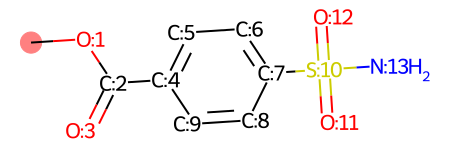

In [3]:
ligand = Chem.MolFromSmiles(ligands.r_x0161)
ligand.__sssAtoms = [0]
mol_with_atom_index(copy.deepcopy(ligand))

Initializing `moldrug.utils.GA` 

In [4]:
maxiter = 3
popsize = 20
njobs = 2

out = utils.GA(
    seed_mol=ligand,
    maxiter=maxiter,
    popsize=popsize,
    crem_db_path = crem_db_path,
    pc = 1,
    get_similar = False,
    mutate_crem_kwargs = {
        'radius':3,
        'min_size':0,
        'max_size':0,
        'min_inc':2,
        'max_inc':6,
        'replace_ids':[0],
        'ncores':cpu_count(),
    },
    costfunc = fitness.Cost,
    costfunc_kwargs = {
        'vina_executable': 'vina',
        'receptor_pdbqt_path': r_x0161_file,
        'boxcenter' : boxes.r_x0161["A"]['boxcenter'] ,
        'boxsize': boxes.r_x0161["A"]['boxsize'],
        'exhaustiveness': 4,
        'ncores': int(cpu_count() / njobs),
        'num_modes': 1,
    },
    save_pop_every_gen = 20,
    deffnm = os.path.join(tmp_path.name, 'specific_position'),
    AddHs=True
)

As you can see in the `mutate_crem_kwargs` we are substituting hydrogen atoms by fragments between 2 and 6 heavy atoms; and only will be used for replace the carbon atom with index "0". However, after the first generation and a new fragments is added, all the atoms of the new fragments will be considered also for mutations. In other words: `moldrug.utils.GA` will internally update the value of `replace_ids` adding the index of the atoms added by CReM in the previous generation.

Check that the `AddHs` is set to `True`. This is needed if we want to work with the hydrogens atoms of the molecule. 

In [5]:
out(njobs=njobs)



Creating the first population with 20 members:


100%|██████████| 20/20 [01:08<00:00,  3.43s/it]

Initial Population: Best individual: Individual(idx = 13, smiles = C=C(COC(=O)c1ccc(S(N)(=O)=O)cc1)C(=O)OC, cost = 0.8845608398910665)
File /tmp/tmpnweb7fv_/specific_position_pop.sdf was createad!


Evaluating generation 1 / 3:


100%|██████████| 20/20 [02:05<00:00,  6.29s/it]

Generation 1: Best Individual: Individual(idx = 13, smiles = C=C(COC(=O)c1ccc(S(N)(=O)=O)cc1)C(=O)OC, cost = 0.8845608398910665).



Note: The mutation on Individual(idx = 1, smiles = C=C(Cl)COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 1.0) did not work, it will be returned the same individual
Evaluating generation 2 / 3:


100%|██████████| 14/14 [01:30<00:00,  6.44s/it]

Generation 2: Best Individual: Individual(idx = 43, smiles = NS(=O)(=O)c1ccc(C(=O)OCC2CCC(CO)O2)cc1, cost = 0.8088443911844957).



Note: The mutation on Individual(idx = 1, smiles = C=C(Cl)COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 1.0) did not work, it will be returned the same individual
Evaluating generation 3 / 3:


100%|██████████| 17/17 [01:51<00:00,  6.57s/it]

File /tmp/tmpnweb7fv_/specific_position_pop.sdf was createad!
Generation 3: Best Individual: Individual(idx = 43, smiles = NS(=O)(=O)c1ccc(C(=O)OCC2CCC(CO)O2)cc1, cost = 0.8088443911844957).


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

The simulation finished successfully after 3 generations with a population of 20 individuals. A total number of 68 Individuals were seen during the simulation.
Initial Individual: Individual(idx = 0, smiles = COC(=O)c1ccc(S(N)(=O)=O)cc1, cost = 1.0)
Final Individual: Individual(idx = 43, smiles = NS(=O)(=O)c1ccc(C(=O)OCC2CCC(CO)O2)cc1, cost = 0.8088443911844957)
The cost function droped in 0.1911556088155043 units.

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

Total time (3 generations): 412.24 (s).
Finished at Thu Aug 25 15:33:10 2022.



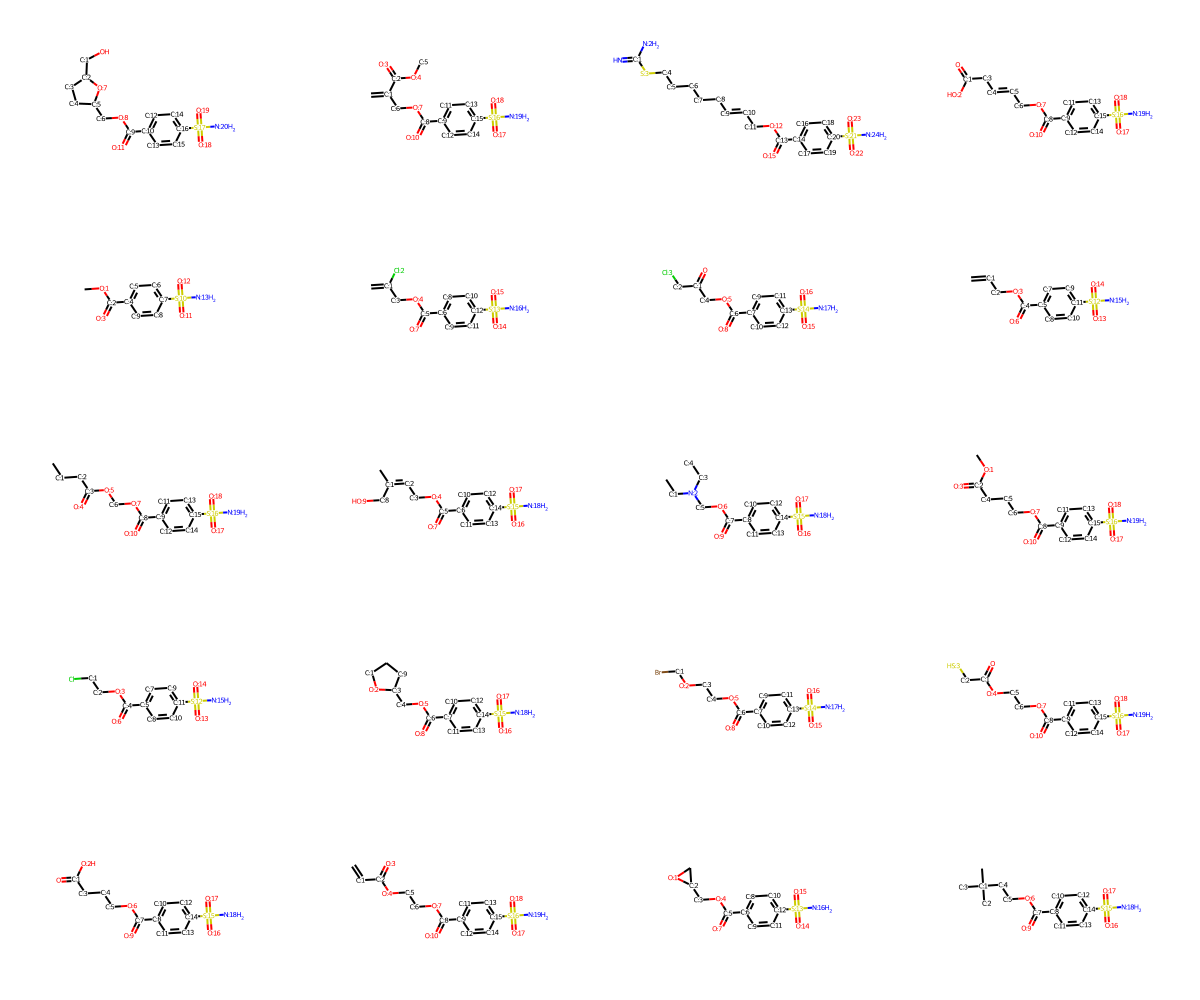

In [6]:
mol_list = [Chem.RemoveHs(m.mol) for m in out.pop]
AllChem.Compute2DCoords(ligand)
_ = [AllChem.GenerateDepictionMatching2DStructure(m,Chem.RemoveHs(ligand)) for m in mol_list]
drawgrid([mol_with_atom_index(Chem.RemoveHs(m)) for m in mol_list])

As you can see only the selected atom is the one submitted to modifications. Also, is evident that the numeration of the molecules are **different**. However this is not a problem for `moldrug.utils.GA`, it is smart enough to identify those changes on numeration during the generations.

**Known issues**:
1. Symmetric molecules! If, for example, we provided the atom index `[5]` instead of `[0]` could be that also the position `9` is submitted to mutation.
2. If for the molecule CCC(O)CC the oxygen atom is submitted to mutation and one of the products is CCCC(=O)CC; the last two atoms will be also considered for mutation in the next generation. This undesired behavior is relies on the use of the MCS to detect what are the "new" atoms in the offspring respect to the parent molecule. The use of [Disconnected Maximum Common Substructures under Constraints](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00741) might solve this issue, but we have not tested yet such approach. 